---
title: "Analog Gravity: Lensing by Density Gradients"
author: "Raúl Chiclano"
date: "2025-11-30"
categories: [gravity, relativity]
description: "Visualizing light bending in a variable density medium."
format:
  html:
    code-fold: true
execute:
  freeze: true
---

We simulate a photon (wave packet) passing near a massive object (low density region). The variation in the speed of sound $c_s(\rho)$ causes the wavefront to tilt, reproducing gravitational lensing via refraction.

Generando la métrica curva (Relajación)...
Fondo estable generado.


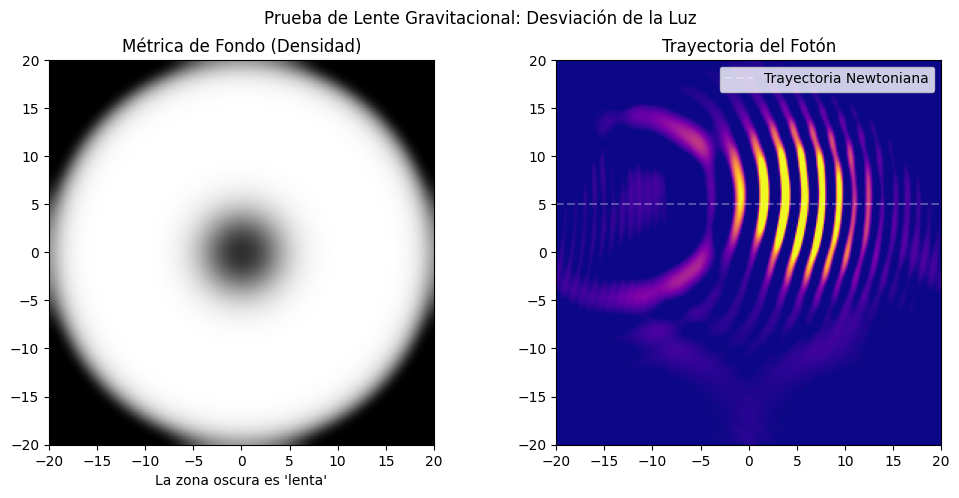

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# ==========================================
# 1. CONFIGURACIÓN DEL ESPACIO-TIEMPO
# ==========================================

N = 256             # Resolución alta para ver el paquete de ondas
L = 40.0            # Espacio amplio
dt = 0.01           # Paso de tiempo
g = 1.0             # Interacción
rho_0 = 1.0         # Densidad base

# Rejilla
x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]

# Espacio k
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
KX, KY = np.meshgrid(k, k)
K2 = KX**2 + KY**2

# ==========================================
# 2. EL "CUERPO MASIVO" (POTENCIAL EXTERNO)
# ==========================================
# Creamos un potencial repulsivo en el centro.
# Esto reduce la densidad del fluido (rho baja -> velocidad de la luz baja).
# Esto simula la métrica curva alrededor de una estrella.

R_center = np.sqrt(X**2 + Y**2)
V_star_amp = 1.5 * g * rho_0  # Altura del potencial
V_star_width = 4.0            # Radio de la "estrella"
V_ext = V_star_amp * np.exp(-(R_center / V_star_width)**2)

# Potencial de bordes (absorbente suave)
V_trap = 0.1 * (R_center / (0.45*L))**20
V_total = V_ext + V_trap

# ==========================================
# 3. PREPARACIÓN DEL FONDO (MÉTRICA CURVA)
# ==========================================
# Usamos Tiempo Imaginario para crear el "espacio curvo" estático
# (el agujero de densidad causado por la estrella).

print("Generando la métrica curva (Relajación)...")
Psi_bg = np.sqrt(rho_0) * np.ones((N, N), dtype=complex) # Fondo plano inicial
dt_im = 0.01

for i in range(300):
    # Paso Potencial
    rho = np.abs(Psi_bg)**2
    Psi_bg *= np.exp(-(V_total + g*rho) * dt_im)
    # Renormalización local aproximada (mantener rho_0 lejos del centro)
    Psi_bg *= np.sqrt(rho_0) / np.max(np.abs(Psi_bg[-1,:])) 
    # Paso Cinético
    Psi_k = np.fft.fft2(Psi_bg)
    Psi_k *= np.exp(-(K2/2)*dt_im)
    Psi_bg = np.fft.ifft2(Psi_k)

print("Fondo estable generado.")

# ==========================================
# 4. INYECCIÓN DEL FOTÓN (PAQUETE DE ONDAS)
# ==========================================

# Parámetros del Fotón
k_photon = 3.0      # Momento (velocidad inicial hacia la derecha)
y_impact = 5.0      # Parámetro de impacto (pasa por encima del centro)
x_start = -15.0     # Empieza a la izquierda
width_photon = 1.5  # Ancho del paquete

# Construcción del paquete gaussiano
Packet = 0.3 * np.sqrt(rho_0) * \
         np.exp(-((X - x_start)**2 + (Y - y_impact)**2) / (2*width_photon**2)) * \
         np.exp(1j * k_photon * X)

# Sumamos el fotón al fondo curvado
Psi = Psi_bg + Packet

# ==========================================
# 5. SIMULACIÓN Y VISUALIZACIÓN
# ==========================================

# Operador de evolución real
U_kin = np.exp(-1j * (K2/2) * dt)

def step(psi_in):
    # Potencial estático + No linealidad dinámica
    psi_mod = psi_in * np.exp(-1j * (V_total + g*np.abs(psi_in)**2) * (dt/2))
    psi_k = np.fft.fft2(psi_mod)
    psi_k *= U_kin
    psi_mod = np.fft.ifft2(psi_k)
    psi_out = psi_mod * np.exp(-1j * (V_total + g*np.abs(psi_mod)**2) * (dt/2))
    return psi_out

# Configuración de Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Prueba de Lente Gravitacional: Desviación de la Luz")

# Panel 1: El Fondo (La Métrica)
# Mostramos la densidad del fondo para ver el "pozo gravitatorio"
im1 = ax1.imshow(np.abs(Psi_bg)**2, extent=[-L/2, L/2, -L/2, L/2], 
                 cmap='gray', origin='lower')
ax1.set_title("Métrica de Fondo (Densidad)")
ax1.set_xlabel("La zona oscura es 'lenta'")

# Panel 2: El Fotón (La Perturbación)
# Restamos el fondo para ver solo la onda viajera
diff = np.abs(Psi)**2 - np.abs(Psi_bg)**2
im2 = ax2.imshow(diff, extent=[-L/2, L/2, -L/2, L/2], 
                 cmap='plasma', origin='lower', vmin=0, vmax=0.1)
ax2.set_title("Trayectoria del Fotón")
ax2.axhline(y=y_impact, color='white', linestyle='--', alpha=0.3, label="Trayectoria Newtoniana")
ax2.legend(loc='upper right')

def update(frame):
    global Psi
    for _ in range(4):
        Psi = step(Psi)
    
    # Visualizamos solo la perturbación positiva (el fotón)
    photon_density = np.abs(Psi)**2 - np.abs(Psi_bg)**2
    im2.set_data(photon_density)
    
    return im1, im2

ani = animation.FuncAnimation(fig, update, frames=150, interval=30, blit=True)
display(HTML(ani.to_html5_video()))